In [1]:
%matplotlib inline

In [15]:
import datetime
import numpy as np 
import pandas as pd 
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.learning_curve import learning_curve
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics
from sklearn import svm
from sklearn import preprocessing
from sklearn import cross_validation
import xgboost as xgb
import matplotlib.pyplot as plt
import prettyplotlib as ppl
import brewer2mpl
import random
from operator import itemgetter
import time
import copy

In [3]:
set2 = brewer2mpl.get_map('Set2', 'qualitative', 8).mpl_colors

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 16,
        }
plt.rc('font',family='serif')
plt.rc('font', size=16)
plt.rc('font', weight='bold')
plt.style.use('fivethirtyeight')
    
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 6 and height to 6
fig_size[0] = 6
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

### Load Data

In [4]:
train = pd.read_csv('data/act_train.csv', dtype={'people_id': np.str,
                               'activity_id': np.str,
                               'outcome': np.int8}, parse_dates=['date'])
test = pd.read_csv('data/act_test.csv', dtype={'people_id': np.str,
                              'activity_id': np.str}, parse_dates=['date'])
people = pd.read_csv('data/people.csv', dtype={'people_id': np.str,
                              'activity_id': np.str,
                              'char_38': np.int32},parse_dates=['date'])

### Cleanup Data - Date, FillNaN etc

In [5]:
def date_to_julian_day(row):
    """Returns the Julian day number of a date."""
    date_format = '%m/%d%Y'
    recorded_date = row['date']
    a = (14 - recorded_date.month)//12
    y = recorded_date.year + 4800 - a
    m = recorded_date.month + 12*a - 3
    return (recorded_date.day + ((153*m + 2)//5) + 365*y + y//4 - y//100 + y//400 - 320450)**0.5

In [6]:
print("Process tables...")
for table in [train, test]:
        table['year'] = table['date'].dt.year
        table['month'] = table['date'].dt.month
        table['day'] = table['date'].dt.day
        table['day_of_week'] = table['date'].dt.dayofweek
        table['julian'] = table.apply(date_to_julian_day, axis=1)
        table.drop('date', axis=1, inplace=True)
        table['activity_category'] = table['activity_category'].str.lstrip('type ').astype(np.int32)
        for i in range(1, 11):
            table['char_' + str(i)].fillna('type -999', inplace=True)
            table['char_' + str(i)] = table['char_' + str(i)].str.lstrip('type ').astype(np.int32)
people['year'] = people['date'].dt.year
people['month'] = people['date'].dt.month
people['day'] = people['date'].dt.day
people['day_of_week_people'] = people['date'].dt.dayofweek
people['julian'] = people.apply(date_to_julian_day, axis=1)
people.drop('date', axis=1, inplace=True)
people['group_1'] = people['group_1'].str.lstrip('group ').astype(np.int32)
for i in range(1, 10):
        people['char_' + str(i)] = people['char_' + str(i)].str.lstrip('type ').astype(np.int32)
for i in range(10, 38):
        people['char_' + str(i)] = people['char_' + str(i)].astype(np.int32)

print("Merge...")
train = pd.merge(train, people, how='left', on='people_id', left_index=True)
train.fillna(-999, inplace=True)
test = pd.merge(test, people, how='left', on='people_id', left_index=True)
test.fillna(-999, inplace=True)

Process tables...
Merge...


### Select Features for Model

In [7]:
feature_cols = [col for col in train.columns if col not in ['people_id', 'activity_id','outcome']]
target = 'outcome'

In [8]:
print('Length of train: ', len(train))
print('Length of test: ', len(test))
print('Features [{}]: {}'.format(len(feature_cols), sorted(feature_cols)))


Length of train:  2197291
Length of test:  498687
Features [60]: ['activity_category', 'char_10_x', 'char_10_y', 'char_11', 'char_12', 'char_13', 'char_14', 'char_15', 'char_16', 'char_17', 'char_18', 'char_19', 'char_1_x', 'char_1_y', 'char_20', 'char_21', 'char_22', 'char_23', 'char_24', 'char_25', 'char_26', 'char_27', 'char_28', 'char_29', 'char_2_x', 'char_2_y', 'char_30', 'char_31', 'char_32', 'char_33', 'char_34', 'char_35', 'char_36', 'char_37', 'char_38', 'char_3_x', 'char_3_y', 'char_4_x', 'char_4_y', 'char_5_x', 'char_5_y', 'char_6_x', 'char_6_y', 'char_7_x', 'char_7_y', 'char_8_x', 'char_8_y', 'char_9_x', 'char_9_y', 'day_of_week', 'day_of_week_people', 'day_x', 'day_y', 'group_1', 'julian_x', 'julian_y', 'month_x', 'month_y', 'year_x', 'year_y']


### Function to Model ROC

In [9]:
def plot_roc(model, title):
    model.fit(X_train, y_train)
    actuals = y_train
    predictions  = model.predict(X_train)
    
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(actuals, predictions)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    
    actuals_t = y_test
    predictions_t  = model.predict(X_test)
    false_positive_rate_t, true_positive_rate_t, thresholds_t = metrics.roc_curve(actuals_t, predictions_t)
    roc_auc_t = metrics.auc(false_positive_rate_t, true_positive_rate_t)

    # Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(false_positive_rate, true_positive_rate, 'r', label='Training = %0.2f'% roc_auc)
    plt.plot(false_positive_rate_t, true_positive_rate_t, 'g', label='Test = %0.2f'% roc_auc_t)
    plt.fill(false_positive_rate, true_positive_rate, facecolor='blue', alpha=0.5, )
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontdict=font)
    plt.ylabel('True Positive Rate', fontdict=font)
    title = "Redhat Dataset " + title
    plt.title(title, fontdict=font)
    plt.legend(loc="lower right", fontsize=20)
    #plt.savefig(name, bbox_inches='tight')
    plt.show()
    return roc_auc 

In [10]:
def plot_learning_curve(estimator, title, ylim=None):
    
    train_sizes=np.linspace(.1, 1.0, 5)
    cv=None
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    title = "RedHat Dataset - " + title
    plt.title(title, y=1.08, fontdict=font)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples", fontdict=font)
    plt.ylabel("Score", fontdict=font)
    plt.grid(True)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.plot(train_sizes, train_scores_mean, color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, color="g",
             label="Cross-validation score")
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

### Random Forest Model

In [45]:
model = ensemble.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [46]:
print(model)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [47]:
X = train[feature_cols]
Xt = test[feature_cols]
y = train['outcome']

### Scale Data

In [48]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
Xt = scaler.transform(Xt)

In [39]:
scores = cross_validation.cross_val_score(model, X, y, n_jobs=-1, scoring = 'roc_auc', cv=5)
print(scores)
print(float(sum(scores))/len(scores))

[ 0.94718254  0.92755234  0.94751263  0.92000344  0.93052383]
0.9345549546654437


In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

(1757832, 60)
(1757832,)


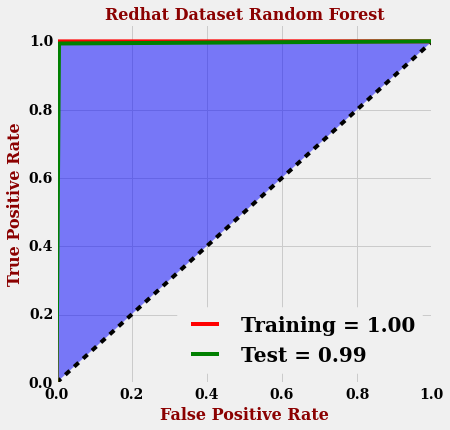

0.9997785157819139

In [107]:
plot_roc(model, "Random Forest")

In [49]:
model.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Train Using Top Ten Important Features

In [50]:
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), feature_cols), 
             reverse=True))
ft = (sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), feature_cols), 
             reverse=True))
ft = ft[:21]
print("")
important_features = [x[1] for x in ft]
print(important_features)

Features sorted by their score:
[(0.1895, 'char_38'), (0.1444, 'char_2_y'), (0.13170000000000001, 'group_1'), (0.043400000000000001, 'char_7_y'), (0.031600000000000003, 'julian_y'), (0.030599999999999999, 'day_y'), (0.027699999999999999, 'julian_x'), (0.025000000000000001, 'char_8_y'), (0.0246, 'char_6_y'), (0.021299999999999999, 'month_y'), (0.019800000000000002, 'char_3_y'), (0.0195, 'char_34'), (0.019400000000000001, 'char_1_y'), (0.017899999999999999, 'char_5_y'), (0.017100000000000001, 'char_4_y'), (0.016899999999999998, 'month_x'), (0.0166, 'day_of_week_people'), (0.0154, 'char_9_y'), (0.015100000000000001, 'char_13'), (0.012200000000000001, 'char_36'), (0.0114, 'day_x'), (0.010999999999999999, 'char_10_x'), (0.0103, 'char_17'), (0.010200000000000001, 'char_22'), (0.0101, 'char_37'), (0.0094999999999999998, 'char_20'), (0.0094000000000000004, 'char_21'), (0.0071000000000000004, 'year_y'), (0.0060000000000000001, 'char_31'), (0.0054000000000000003, 'day_of_week'), (0.0051999999999

In [51]:
X = train[important_features]
Xt = test[important_features]
y = train['outcome']

In [55]:
lr_features = ['group_1', 'char_2_x', 'char_38']
X = train[lr_features]
Xt = test[lr_features]
y = train['outcome']

In [56]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
Xt = scaler.transform(Xt)

In [58]:
model = linear_model.LogisticRegression(C=100000.0)

In [59]:
scores = cross_validation.cross_val_score(model, X, y, n_jobs=-1, scoring = 'roc_auc', cv=5)
print(scores)
print(float(sum(scores))/len(scores))

[ 0.89211097  0.87567118  0.89540698  0.9002649   0.88611506]
0.8899138181403877


### Split Train and Validation Set

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

(1757832, 13)
(1757832,)


In [120]:
model = svm.SVC()

In [ ]:
plot_roc(model, "XgBoost")

In [ ]:
print(model)

In [61]:
model = ensemble.RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0,
            warm_start=False)

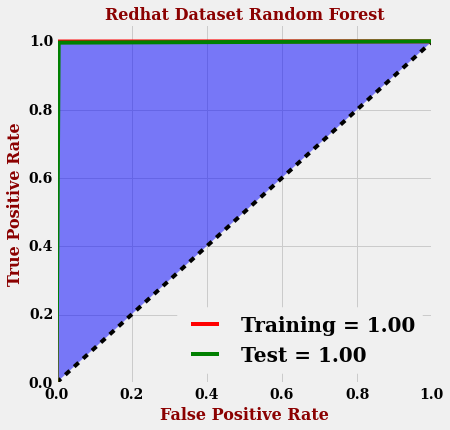

0.99905806752466686

In [62]:
plot_roc(model, "Random Forest")

In [ ]:
plot_learning_curve(model, "Random Forest", ylim=None)

### Grid Search for Random Forest Using All Features

In [63]:
print(model)
print("")
# fit the model
model.fit(X, y)
# summarize the fit of the model
score = model.score(X, y)
print("Classification score using train set: {}\n".format(str(score)))
pd.DataFrame(model.feature_importances_,index=X.columns).sort([0], ascending=False) [:]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Classification score using train set: 0.999298681877



,0
char_38,0.250044
group_1,0.236743
char_2_y,0.112833
julian_x,0.064773
char_7_y,0.064693
julian_y,0.056403
day_y,0.048000
char_8_y,0.042597
char_6_y,0.032421
month_y,0.030330


### Predict on Test Set

In [64]:
y_predict = model.predict_proba(Xt)

In [65]:
print(y_predict)

[[ 0.58333333  0.41666667]
 [ 0.58333333  0.41666667]
 [ 0.15        0.85      ]
 ..., 
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]]


In [66]:
yPred = y_predict[:,1]

In [67]:
current_time = datetime.datetime.now()

In [68]:
sub = pd.DataFrame()
sub['activity_id'] = test['activity_id']
sub['outcome'] = yPred.tolist()
sub.to_csv('submission_rf_' + str(current_time.strftime("%Y-%m-%d-%H-%M")) + '.csv', index=False)